# CS4035 - Cyber Data Analytics
## Lab 3 

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Readme - Please pip install any missing libraries like nltk,mmh3 and any other libraries that you may not have. For installing mmh3, if the pip command gives an error, please use this link https://visualstudio.microsoft.com/visual-cpp-build-tools/ to install Microsoft Visual C++ 14.0 and re-run the pip command. (Once the visual studio installer opens, please click on the C++ build tools and install the pre-selected options.) In addition, we've provided the datasets used in our work as well. All that needs to be done is to provide correct paths when reading in the data. 

In [1]:
#Importing necessary libraries. 
import pandas as pd
import numpy as np
from numpy.linalg import norm
import itertools
import mmh3
import math
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import ngrams
import time
import random
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import datasets
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
#Run this type of command if any libraries are missing. 
#!pip install nltk

## Read the Botnet Data

In [2]:
#Loading in all scenarios.
data0 = pd.read_csv("capture20110817.binetflow")
data1 = pd.read_csv("capture20110818.binetflow")
data2 = pd.read_csv("capture20110819.binetflow")
data3 = pd.read_csv("capture20110818-2.binetflow")
dataMerged =pd.concat([data0,data1,data2,data3])

## 1. Familiarization and discretization task

### Discretizing and visualising selected features for scenario 10. Please read the comments carefully to understand the steps undertaken for this task.

In [3]:
#Using only scenario 10 for the first task.
data = data1.copy()
#Fixing the labels in the dataset. (1-> Botnet, 0->Normal, -1->Background) 
Labels = [] 
for i in data.Label.values:
    if re.search("Background",i)!=None:
        Labels.append(-1)
    elif re.search("Normal",i)!=None:
        Labels.append(0)
    elif re.search("Botnet",i)!=None:
        Labels.append(1)
data["Label"]=Labels
data.Label.unique() 

#Creating new dataframe by removing background netflow data.
data_WB = data.loc[data["Label"]!=-1]

#Converting StartTime to a datetime variable. 
data_WB.loc[:,"StartTime"] = pd.to_datetime(data_WB["StartTime"])

#Printing the nas counts for the columns. 
for col in data_WB.columns:
    if(data_WB[col].isna().sum()):
        print('col_name: '+ col)
        print('count NAs: %d' %data_WB[col].isna().sum())

col_name: Sport
count NAs: 27
col_name: Dport
count NAs: 101196
col_name: State
count NAs: 1227
col_name: sTos
count NAs: 29
col_name: dTos
count NAs: 107104


In [4]:
#We see that sTos and dTos are NOT adding meaningful information. Better to get rid of it. 
data_WB.sTos.unique(),data_WB.dTos.unique()

(array([ 0., nan]), array([ 0., nan]))

In [5]:
#Due to large number of missing values, drop dTos and Dport as it will only cloud results. 
#Removing sTos as it's useless as can be seen above.
data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])

# For the label encoding, replacing nans with default values for State and Sport
# And converting them to be of categorical type. 
data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
data_vis=data_WB_cleaned.copy()

In [6]:
#Converting categorical variables in numerical ones using label encoder to be used for correlation. 
le = preprocessing.LabelEncoder()
categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
for i in categorical_columns:
    data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])
data_M = data_WB_cleaned.loc[data_WB_cleaned["Label"]==1] # This stores data on malicious netflows.
data_NM = data_WB_cleaned.loc[data_WB_cleaned["Label"]==0]# This stores data on normal netflows. 

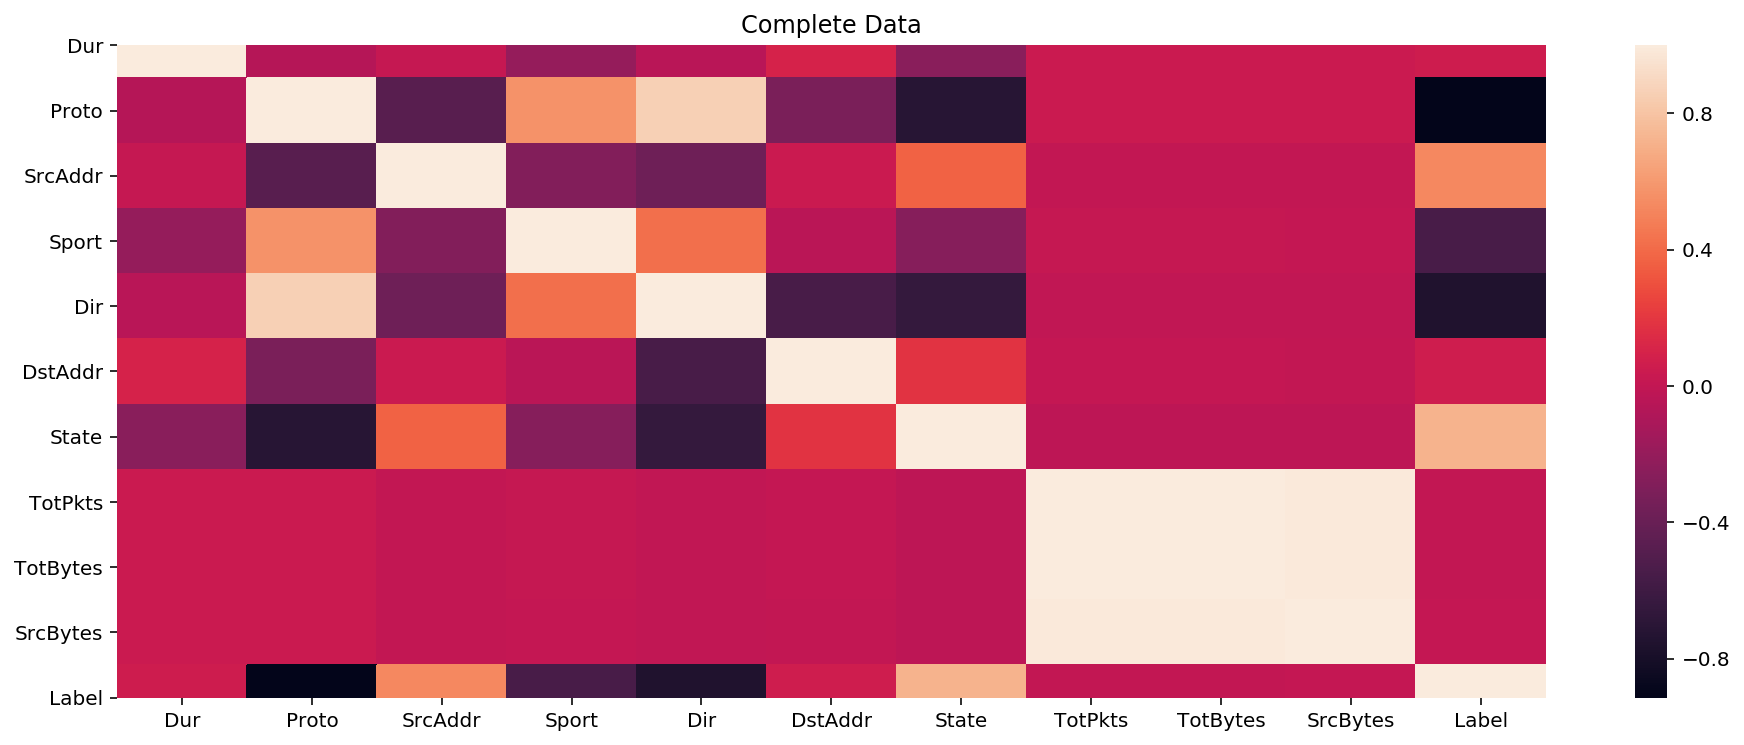

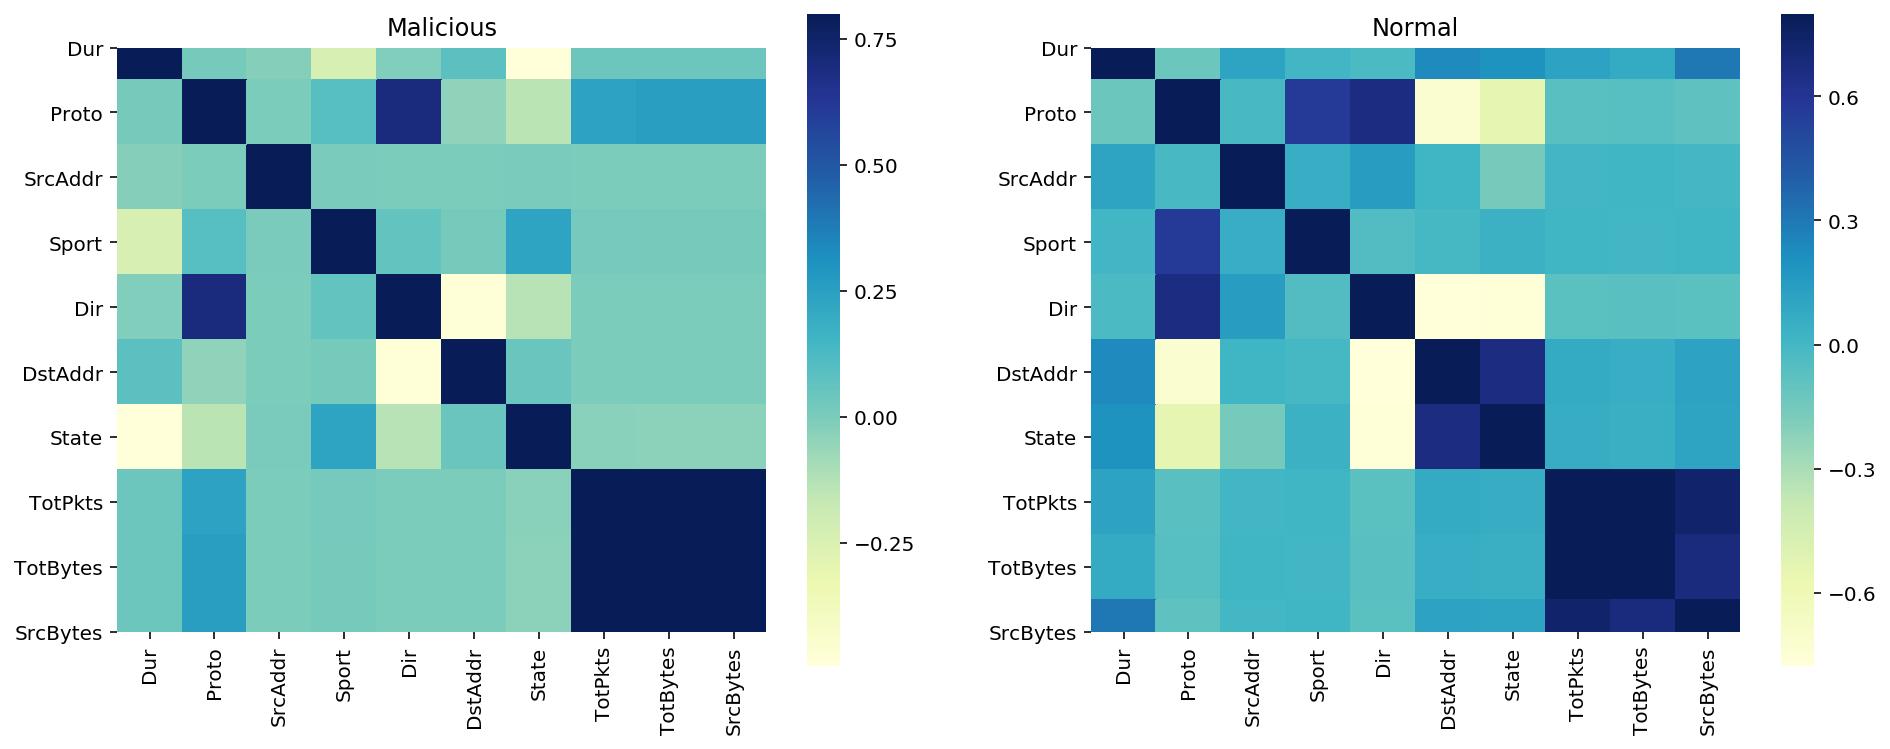

In [7]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(16, 6))
sns.heatmap(data_WB_cleaned.corr())
ax1.set_title('Complete Data')
plt.show()


f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 6))

sns.heatmap(data_M.drop(['Label'], axis=1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Malicious')

sns.heatmap(data_NM.drop(['Label'], axis=1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

In [8]:
#Looking at the correlation of all features with the labels. 
data_WB_cleaned.corr()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
Dur,1.000000,-0.059651,0.019821,-0.202402,-0.045376,0.101189,-0.253972,0.040007,0.041698,0.039328,0.050622
Proto,-0.059651,1.000000,-0.480068,0.570802,0.860547,-0.318632,-0.712716,0.041047,0.042357,0.039165,-0.914309
SrcAddr,0.019821,-0.480068,1.000000,-0.284142,-0.369949,0.036393,0.369286,-0.000524,0.000155,0.003175,0.523478
Sport,-0.202402,0.570802,-0.284142,1.000000,0.417685,-0.033035,-0.269878,0.014761,0.013651,0.009765,-0.553765
Dir,-0.045376,0.860547,-0.369949,0.417685,1.000000,-0.549063,-0.650457,-0.004379,-0.005671,-0.005320,-0.754101
DstAddr,0.101189,-0.318632,0.036393,-0.033035,-0.549063,1.000000,0.179736,0.008281,0.007701,0.000994,0.062006
State,-0.253972,-0.712716,0.369286,-0.269878,-0.650457,0.179736,1.000000,-0.020216,-0.021621,-0.018281,0.718407
TotPkts,0.040007,0.041047,-0.000524,0.014761,-0.004379,0.008281,-0.020216,1.000000,0.998092,0.992488,-0.001117
TotBytes,0.041698,0.042357,0.000155,0.013651,-0.005671,0.007701,-0.021621,0.998092,1.000000,0.991953,-0.000018
SrcBytes,0.039328,0.039165,0.003175,0.009765,-0.005320,0.000994,-0.018281,0.992488,0.991953,1.000000,0.006605


#### Through the correlation plot we determine the most important features in determining whether a data point is malicious or not based on whether they have the high correlation with the label: `Proto`, `Dir`, `State`


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


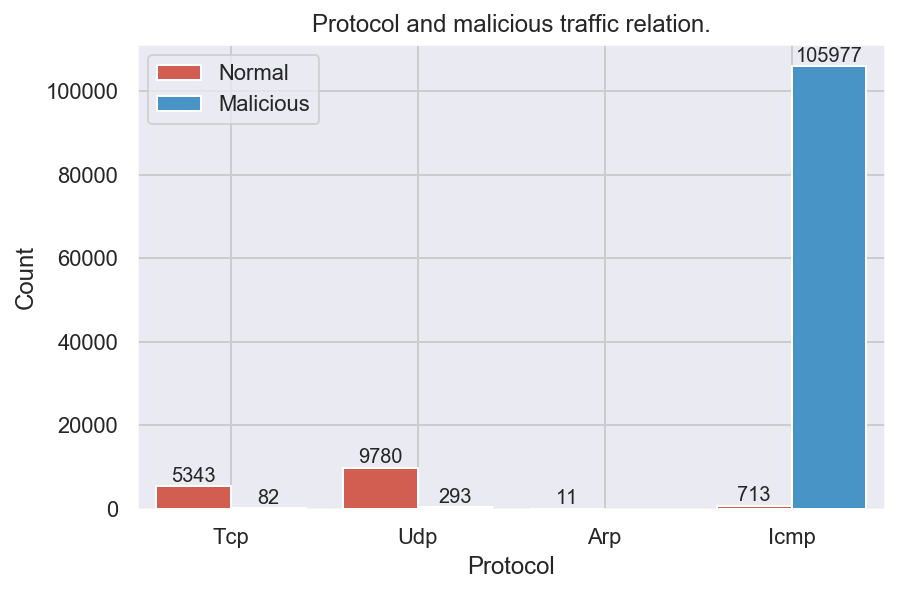

In [9]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Proto", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.set(xticklabels=["Tcp","Udp","Arp","Icmp"])
ax.legend(["Normal","Malicious"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


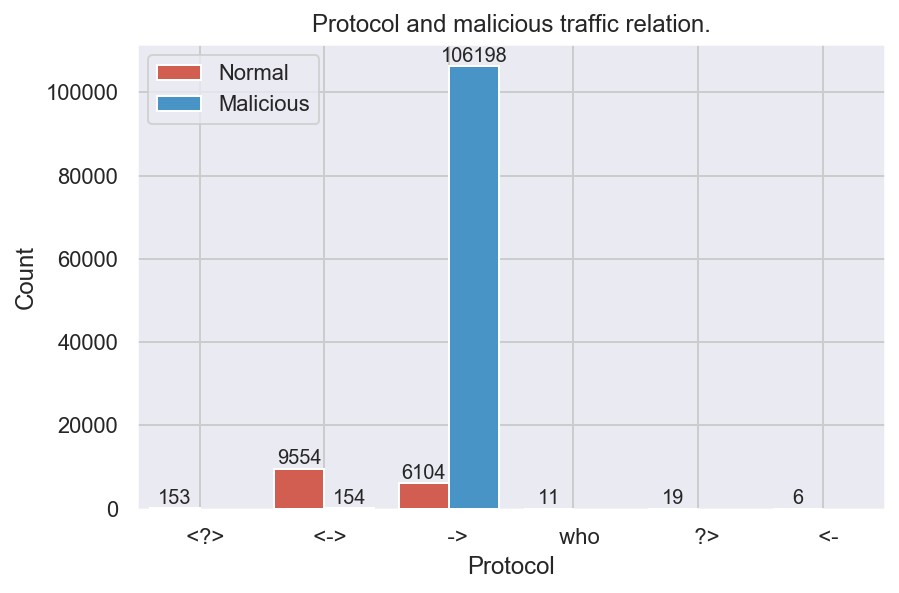

In [10]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Dir", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.legend(["Normal", "Malicious"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

From the below visualisation we can see "Proto" and "Dir" which is already discrete due it being categorical has a major influence on the chance of making a certain record in the netflow data malicious. "State" feature is also very important but the visualisation is not useful due to too many categories. Now returning to the heatmaps of the malicious and normal datasets and observing the correlations for "Proto" and "State" with the other variables, we see that "Proto" has a higher correlation with the "TotBytes" in the malicious dataset than the normal dataset which means, "TotBytes" has a different behaviour for malicious netflows. Similarly, we see the "State" feature has very different correlations with the "Dur" feature between the malicious and normal datasets. With this premise, I believe discretizing the "TotBytes" and "Dur" are going to useful for studying an infected host. 

In [11]:
#Selecting a certain infected host.
data_infected_host = data_M.loc[data_M["SrcAddr"]==12]

Now we plot the within sum of squares distance for both features for varying number of clusters and use the elbow method to select the appropriate number of bins as was done in paper 4 of the assignment's resource section. 

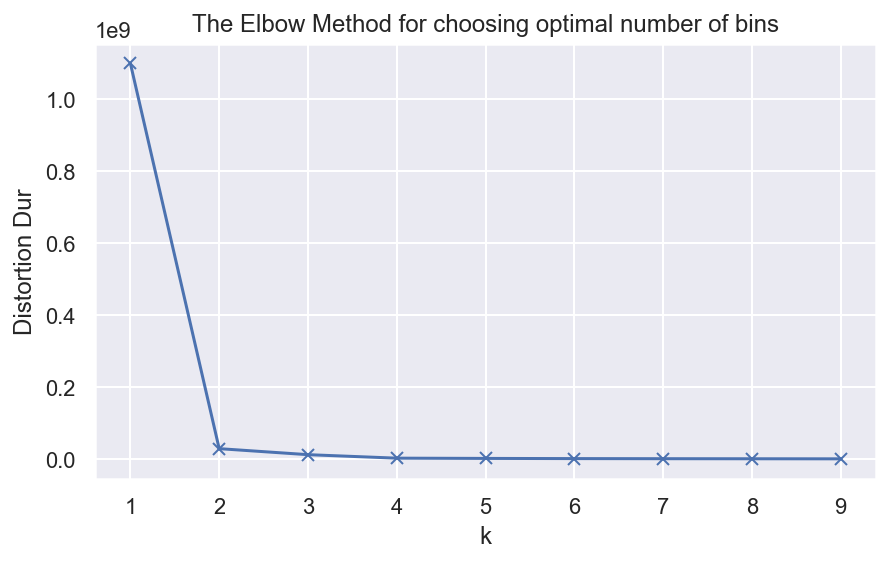

In [12]:
#Calculating Distortions for DUR feature.
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["Dur"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(7,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion Dur')
plt.title('The Elbow Method for choosing optimal number of bins')
plt.show()

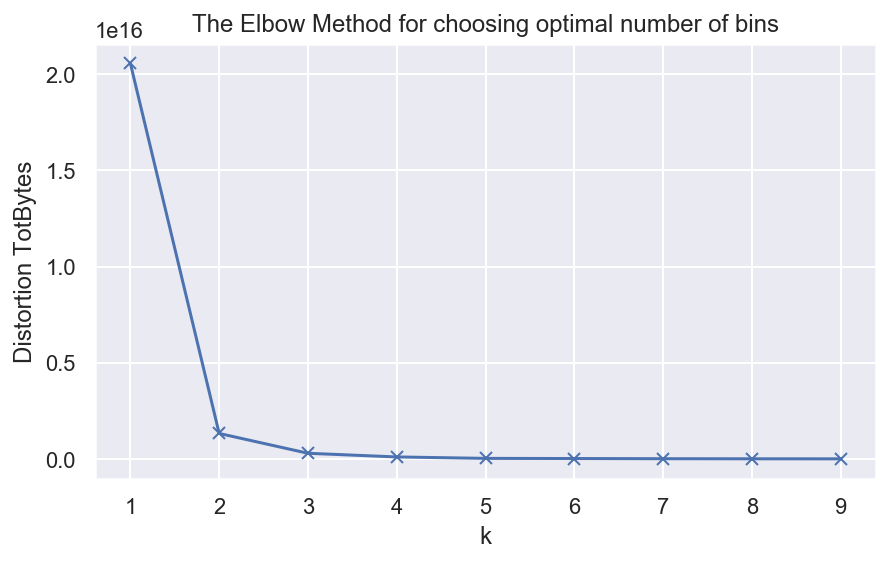

In [13]:
#Distortions for TotBytes
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["TotBytes"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion TotBytes')
plt.title('The Elbow Method for choosing optimal number of bins')
plt.show()

Based on the above plots, we see that selecting 3 bins for both features is reasonable. 

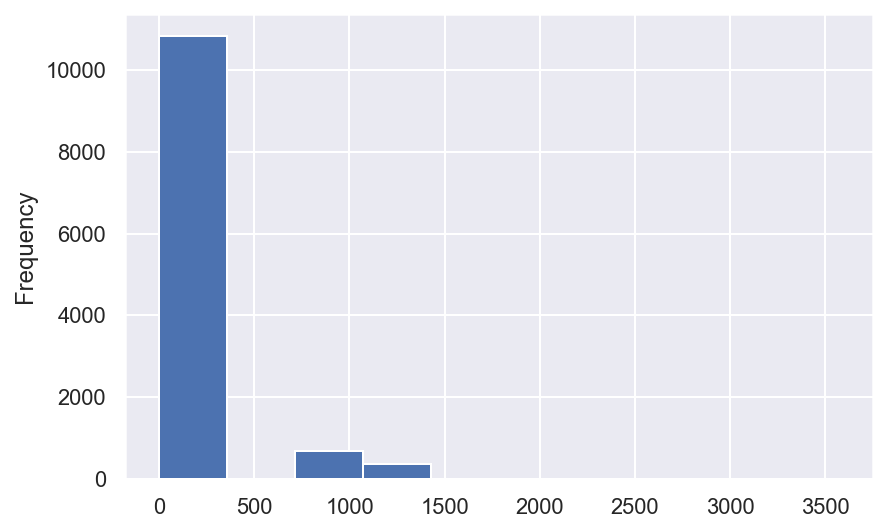

In [14]:
ax=data_infected_host["Dur"].plot(kind="hist")

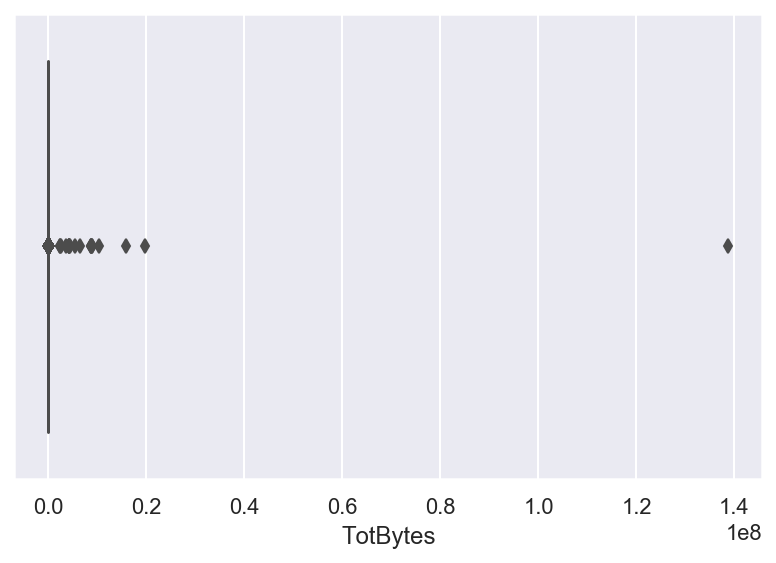

In [15]:
ax=sns.boxplot(data_infected_host["TotBytes"])

As shown by these graphs above, there seems to be a great deal of outliers in both features, therefore I must make then a bit more continous by removing outliers to discretize them better. 

In [16]:
#This range isn't right. 
data_infected_host["TotBytes"].min(),data_infected_host["TotBytes"].max()

(60, 138720832)

In [29]:
TotBytes=data_infected_host["TotBytes"].values

#last 20 values are very large. 
TotBytes_Pure = TotBytes[:-20]

# Getting the outliers to see what they look like for the reviewer.
TotBytes_Outliers=TotBytes[-20:]

#Therefore we have 2 valid intervals based on quantile based discretization and the 3rd will be for the outliers. 
print(str(pd.qcut(TotBytes_Pure, q=2))[199:])


Categories (2, interval[float64]): [(59.999, 1066.0] < (1066.0, 138720832.0]]


In [35]:
#Lets discretize the feature TotBytes now based on the ranges defined by qcut. 
data_infected_host.loc[(data_infected_host['TotBytes']>59.99) &(data_infected_host['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_infected_host.loc[(data_infected_host['TotBytes']>1066) &(data_infected_host['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_infected_host.loc[(data_infected_host['TotBytes']>55432),'New_TotBytes'] = 'Level_3'
data_infected_host["New_TotBytes"].unique()

array(['Level_1', 'Level_2', 'Level_3'], dtype=object)

In [41]:
# Now doing the same for "Dur" feature. This range doesn't look right. 
data_infected_host["Dur"].min(),data_infected_host["Dur"].max()

(0.0, 3570.946045)

In [39]:
data_infected_host.groupby(["Dur"]).count()

,StartTime,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
Dur,,,,,,,,,,,
0.000000,10793,10793,10793,10793,10793,10793,10793,10793,10793,10793,10793
0.000227,1,1,1,1,1,1,1,1,1,1,1
0.000233,1,1,1,1,1,1,1,1,1,1,1
0.000263,1,1,1,1,1,1,1,1,1,1,1
0.000345,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1274.888062,1,1,1,1,1,1,1,1,1,1,1
1274.926147,1,1,1,1,1,1,1,1,1,1,1
1693.866089,1,1,1,1,1,1,1,1,1,1,1


Problem is we cannot get well defined quantiles for such a discontinous array of values. As pd.qcut(Dur,2) This doesn't work. But based on the intuition of clustering based on the values of the data points into 3 groups which was shown before using the elbow method. I'm using the sklearn KBinDiscretizer to create the relevant bins. 

In [31]:
#Lets discretize the feature Dur now.
Dur=data_infected_host["Dur"].values
Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_infected_host.loc[:,"New_Dur"]=Binner.fit_transform(Dur.reshape(-1,1))
data_infected_host.loc[(data_infected_host['New_Dur']==0.0) ,'New_Dur'] = 'Level_1'
data_infected_host.loc[(data_infected_host['New_Dur']==1.0) ,'New_Dur'] = 'Level_2'
data_infected_host.loc[(data_infected_host['New_Dur']==2.0) ,'New_Dur'] = 'Level_3'
data_infected_host["New_Dur"].unique()

array(['Level_1', 'Level_3', 'Level_2'], dtype=object)

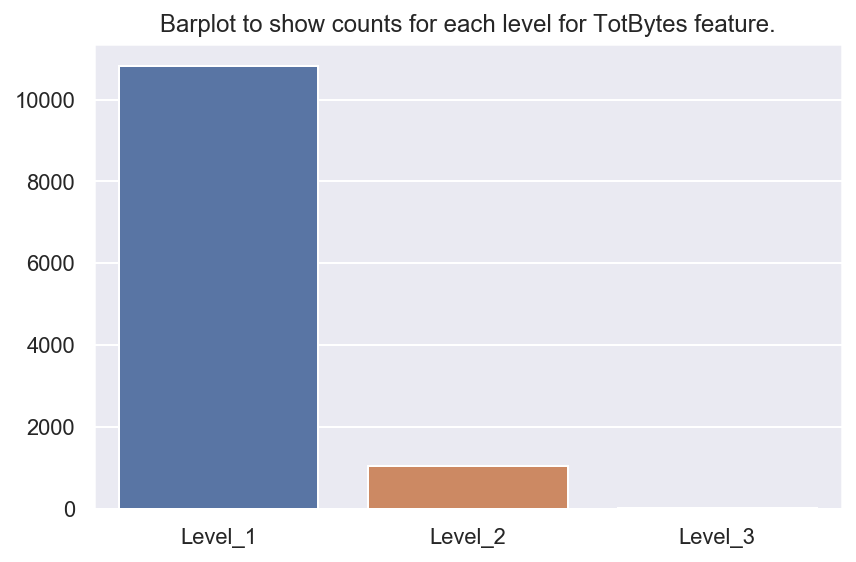

In [33]:
ax=sns.barplot(data_infected_host["New_TotBytes"].value_counts().index,data_infected_host["New_TotBytes"].value_counts().values)
ax.set_title("Barplot to show counts for each level for TotBytes feature.")
plt.show()

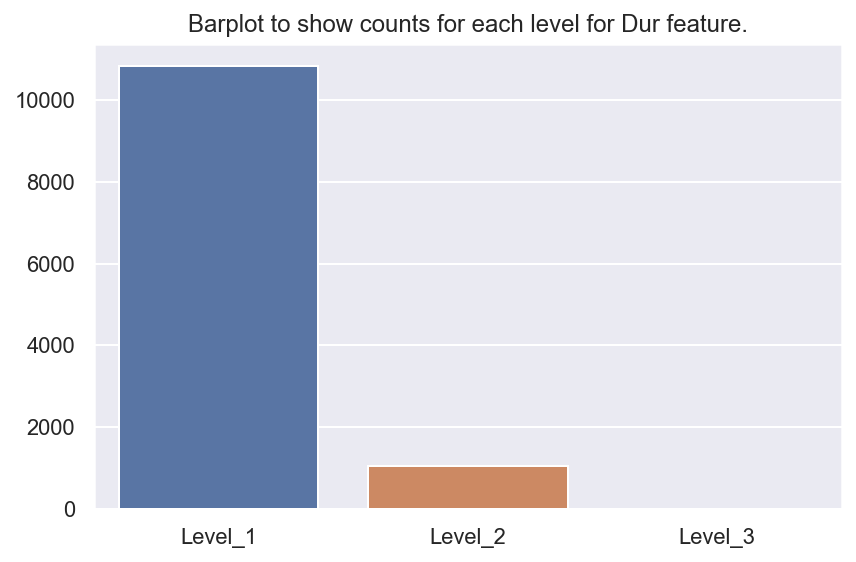

In [34]:
ax=sns.barplot(data_infected_host["New_Dur"].value_counts().index,data_infected_host["New_Dur"].value_counts().values)
ax.set_title("Barplot to show counts for each level for Dur feature.")
plt.show()

Based on this discritization and the barplots of the different levels of the individual features we see that values majorly in the range of level_1 for both "Dur"(0.0-367.65 seconds) and "TotBytes"(66-1066 bytes).

To combine features, we take the cartesian product of the three levels for each of the two features, giving us 9 possibilites as follows:


| Dur           | TotBytes      | Combined_Feature |
| ------------- |:-------------:| :---------------:|
| Level_1       |  Level_1      | Combined_Level_1 |
| Level_1       |  Level_2      | Combined_Level_2 |
| Level_1       |  Level_3      | Combined_Level_3 |
| Level_2       |  Level_1      | Combined_Level_4 | 
| Level_2       |  Level_2      | Combined_Level_5 |   
| Level_2       |  Level_3      | Combined_Level_6 | 
| Level_3       |  Level_1      | Combined_Level_7 |
| Level_3       |  Level_2      | Combined_Level_8 |
| Level_3       |  Level_3      | Combined_Level_9 | 



In [45]:
#Combining features based on the 2 individual discretized features for Dur and TotBytes. 
combined_levels=[]
for i,j in zip(data_infected_host["New_Dur"].values,data_infected_host["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels.append("Combined_Level_9")

data_infected_host.loc[:,"Combined_Levels"]=combined_levels        

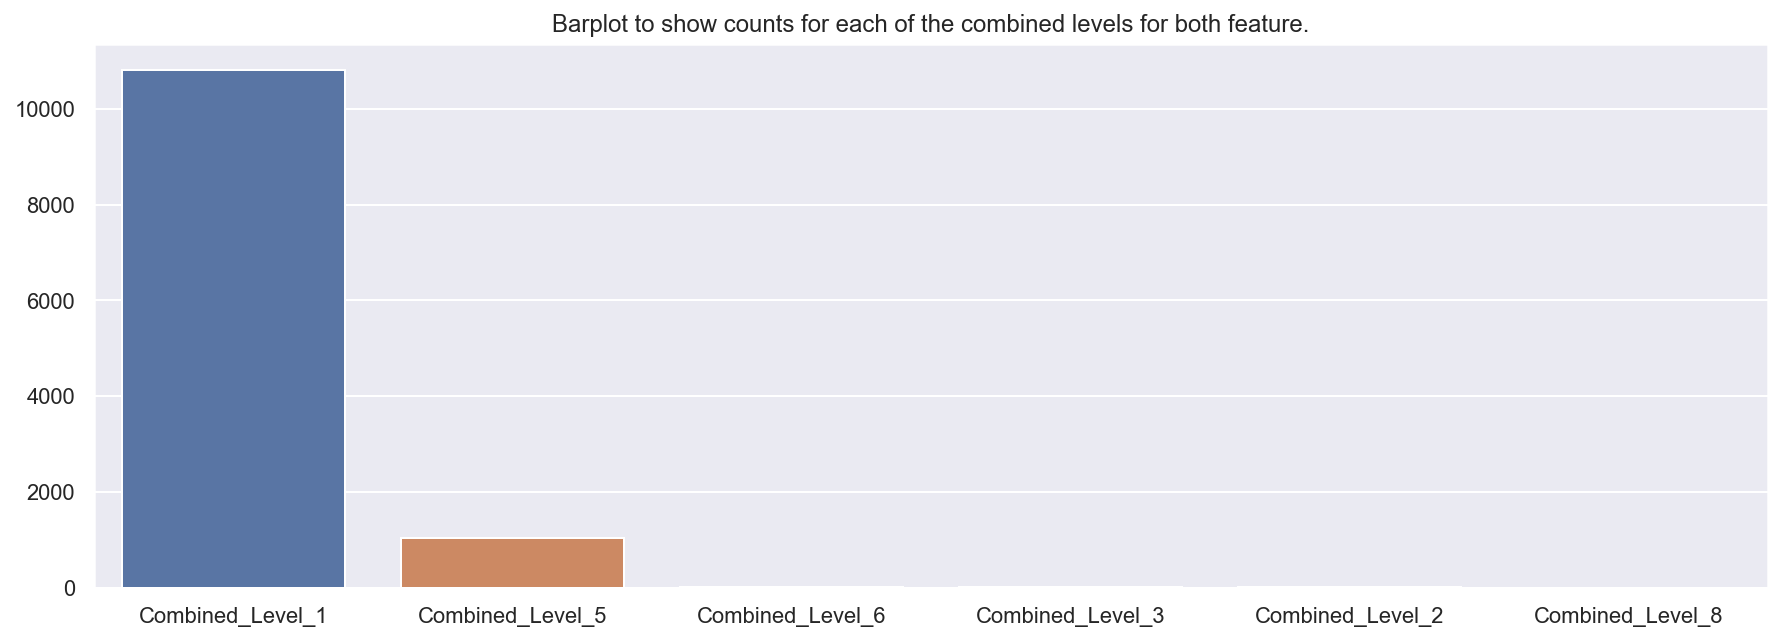

In [46]:
fig,ax= plt.subplots(figsize=(15,5))
ax=sns.barplot(data_infected_host["Combined_Levels"].value_counts().index,data_infected_host["Combined_Levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature.")
plt.show()

Overall, we see that combined_level_1 for this host is quite indicative of malicious activity. This is essentially when Dur and TotBytes level_1s are combined, this is expected ofcourse as they were the most indicative levels for the individual features as well. We then see that combined_level 5 which is a combination of Level_2 from the both features has the second highest frequency. This is ofcourse for a particular infected host.

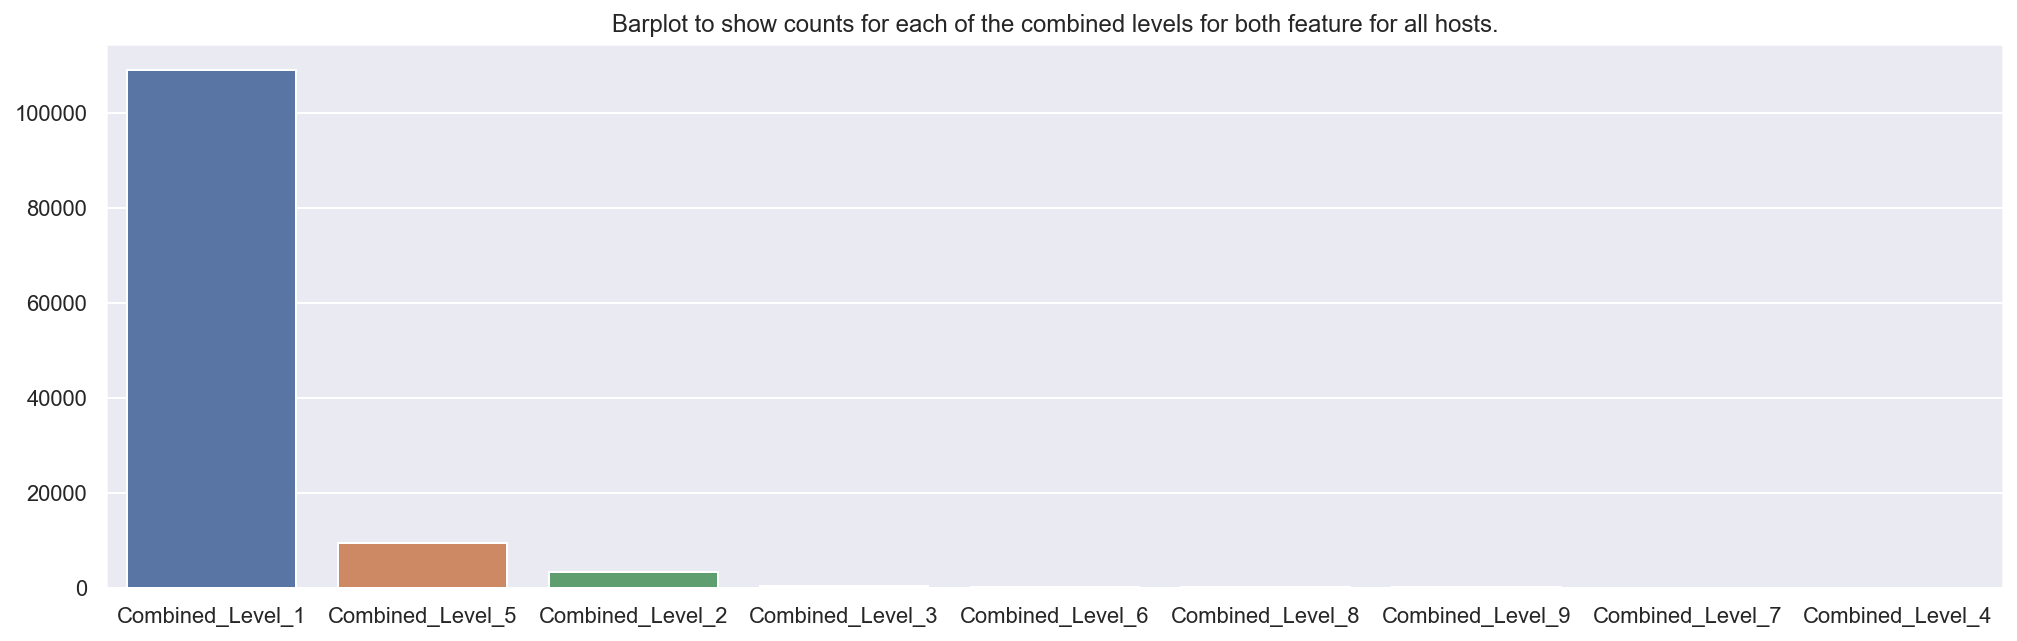

In [54]:
#As a final aspect of the first task, we are asked to discretize our chosen features for every host. 
#Therefore I will do the discretization for the entire dataset without background.
data_discrete= data_WB_cleaned.copy()
#Lets discretize the feature TotBytes
data_discrete.loc[(data_discrete['TotBytes']>59.99) &(data_discrete['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_discrete.loc[(data_discrete['TotBytes']>1066) &(data_discrete['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_discrete.loc[(data_discrete['TotBytes']>55432),'New_TotBytes'] = 'Level_3'
#Lets discretize the feature Dur.
Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_discrete.loc[:,"New_Dur"]=Binner.fit_transform(data_discrete["Dur"].values.reshape(-1,1))
data_discrete.loc[(data_discrete['New_Dur']==0.0) ,'New_Dur'] = 'Level_1'
data_discrete.loc[(data_discrete['New_Dur']==1.0) ,'New_Dur'] = 'Level_2'
data_discrete.loc[(data_discrete['New_Dur']==2.0) ,'New_Dur'] = 'Level_3'
#Creating the combined_feature based on the above two discretizations.
combined_levels_d=[]
for i,j in zip(data_discrete["New_Dur"].values,data_discrete["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_9")

data_discrete["Combined_levels"] = combined_levels_d        
#Plotting the frequencies of the combined_feature levels. 
fig,ax= plt.subplots(figsize=(17,5))
ax=sns.barplot(data_discrete["Combined_levels"].value_counts().index,data_discrete["Combined_levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature for all hosts.")
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


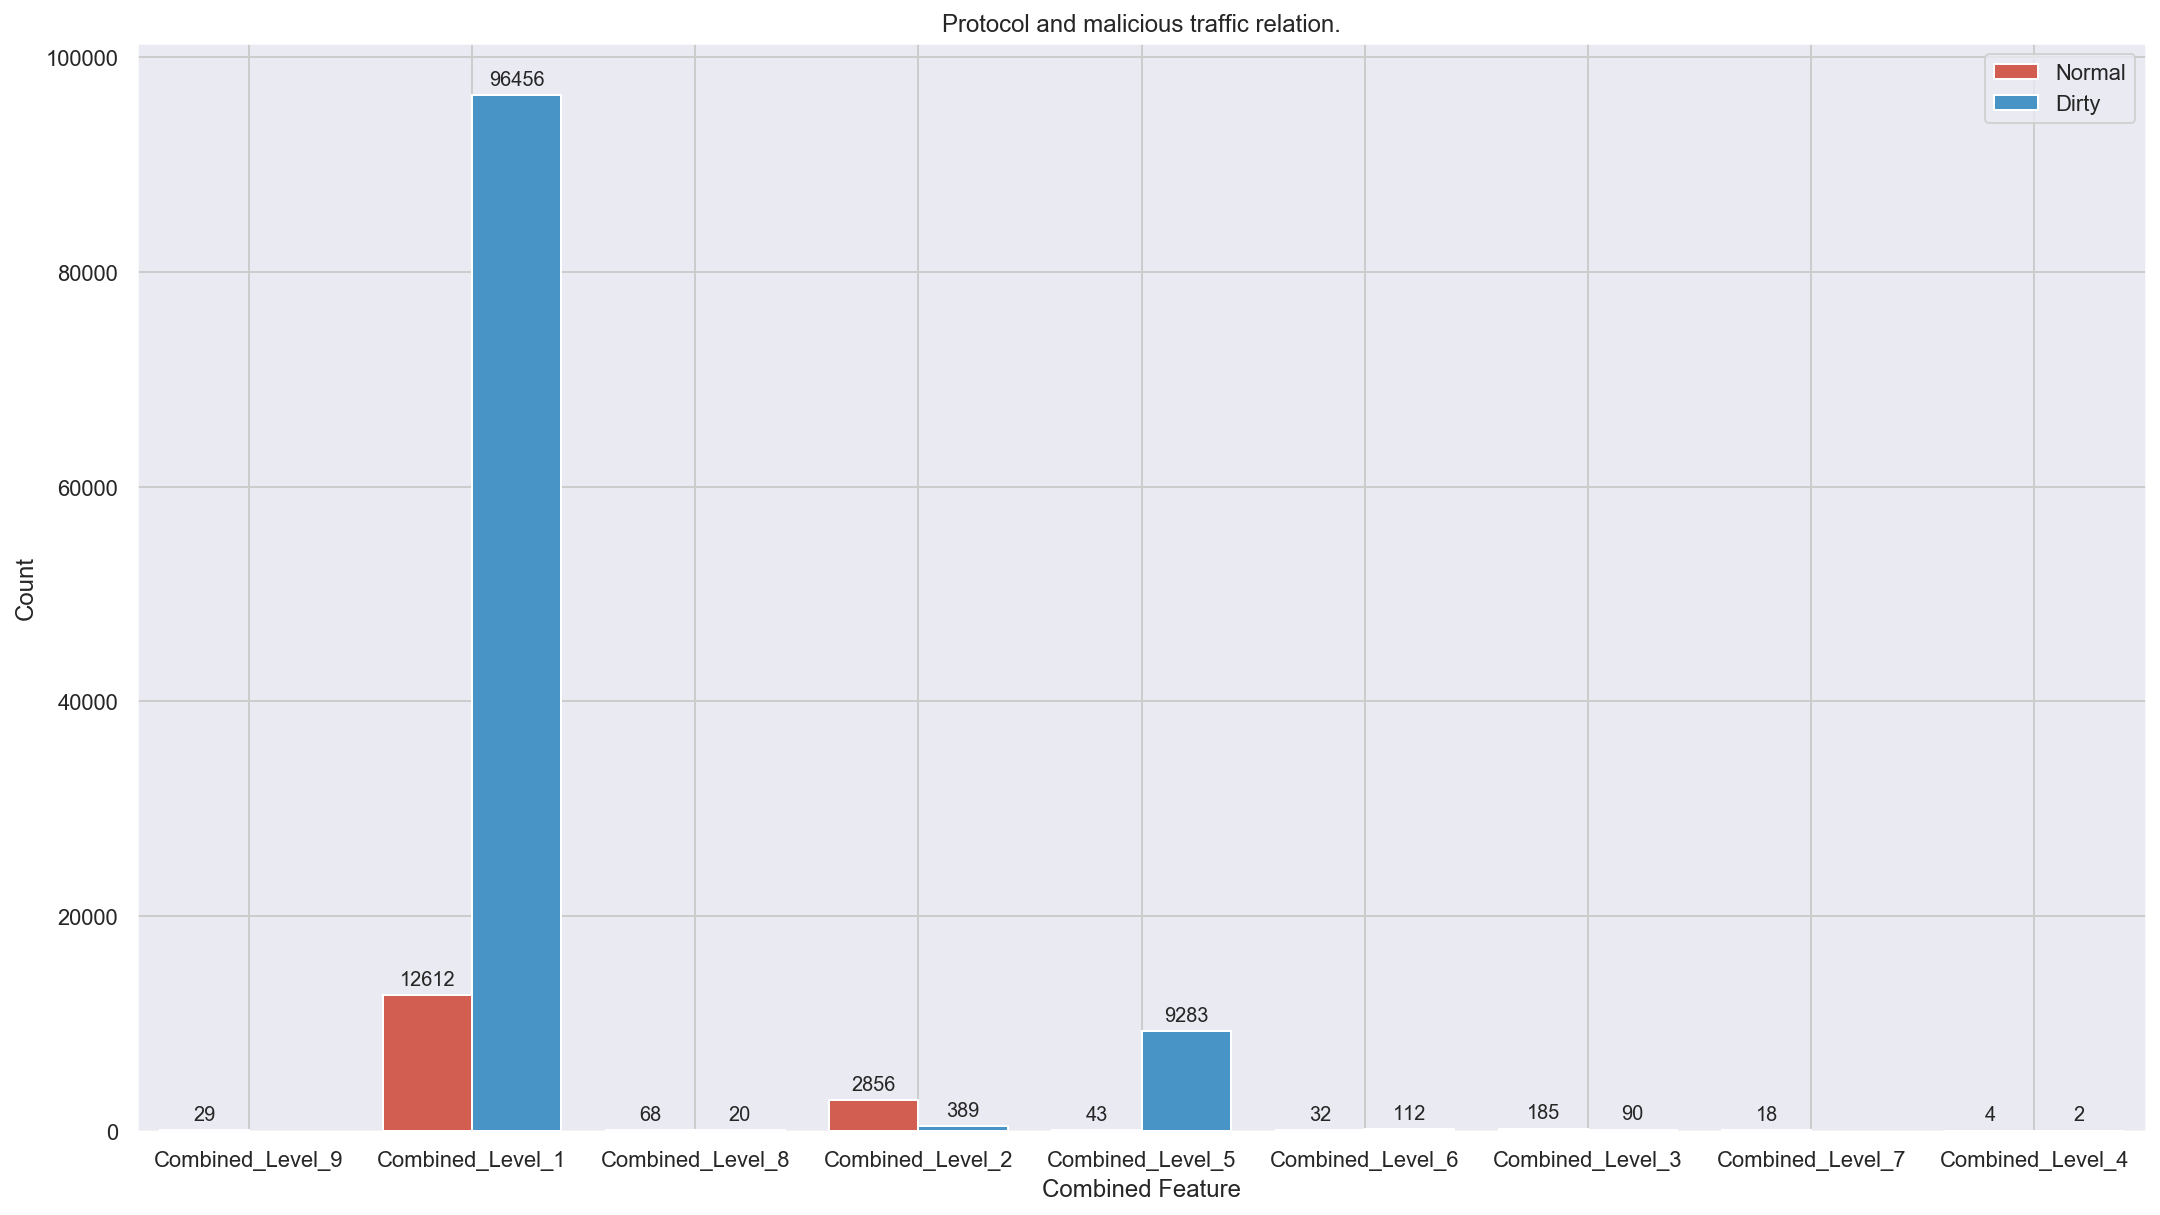

In [55]:
#Plotting relative frequencies of the combined_level features for malicious and normal netflows. 
sns.set(rc={'figure.figsize':(18,10)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Combined_levels", hue="Label", data=data_discrete, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Combined Feature')
ax.legend(["Normal", "Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

This figure gives us a count for each of the levels of the combined_features for malicious and normal netflows. We see combined_level_1 and 5 are majorily representing malicious netflows.

## 2. Frequent task – Aditya Kunar

### 2a. Use the SPACE SAVING algorithm

In [56]:
#Without space saving to compare results with space saving.
from nltk import ngrams

#These are the values of my combined_feature.
Combined_feature=data_discrete.Combined_levels.values

#Creating the different n-grams.
n = 3
threegrams = ngrams(Combined_feature, n)

#Creating a dictionary that stores the counts for the different ngrams. 
dicky={}
for i in threegrams:
    s = "-"
    s = s.join(i)
    dicky[s] = dicky.get(s, 0) + 1

#Sorting the dictionary.
dicky_sorted={k: v for k, v in sorted(dicky.items(), key=lambda item: -1*item[1])} 
#Returning top 10 as demanded in the task.
top10 = {k: dicky_sorted[k] for k in list(dicky_sorted)[:10]}
top10

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 88942,
 'Combined_Level_1-Combined_Level_5-Combined_Level_1': 7687,
 'Combined_Level_1-Combined_Level_1-Combined_Level_5': 7656,
 'Combined_Level_5-Combined_Level_1-Combined_Level_1': 7643,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 1633,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 1632,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 1390,
 'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1023,
 'Combined_Level_5-Combined_Level_1-Combined_Level_5': 772,
 'Combined_Level_1-Combined_Level_5-Combined_Level_5': 742}

In [57]:
#With space saving. 
from nltk import ngrams

Combined_feature=data_discrete.Combined_levels.values


"""
SpaceSpaver-> Here I implement the space saving algorithm as described in the lecture slides. 
              Inputs-:
              feature=> the feature I discretized in task1,
              gram_length=> 3 in our case as we want 3-grams.
              k=> The number of counters we want to use. 
"""
def SpaceSpaver(feature,gram_length,k):
    threegrams = ngrams(feature, gram_length)
    dicky_SV={}
    for i in threegrams:
        s = "-"
        s = s.join(i)
        if len(list(dicky_SV.keys()))<=k:
            dicky_SV[s] = dicky_SV.get(s, 0) + 1
        elif len(list(dicky_SV.keys()))>k:
            if s in list(dicky_SV.keys()):
                dicky_SV[s]+=1
            else:
                keytoR=(min(dicky_SV, key=dicky_SV.get))
                dicky_SV[s] = dicky_SV.pop(keytoR)
                dicky_SV[s]+=1

    dicky_SV_sorted={k: v for k, v in sorted(dicky_SV.items(), key=lambda item: -1*item[1])} 
    top10_SV = {k: dicky_SV_sorted[k] for k in list(dicky_SV_sorted)[:10]}
    return top10_SV

In [58]:
#Using the space-saver with 12 counters. 
top10_SV=SpaceSpaver(Combined_feature,3,12)
top10_SV

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 88942,
 'Combined_Level_1-Combined_Level_5-Combined_Level_1': 7764,
 'Combined_Level_1-Combined_Level_1-Combined_Level_5': 7730,
 'Combined_Level_5-Combined_Level_1-Combined_Level_1': 7714,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 1634,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 1634,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 1392,
 'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1026,
 'Combined_Level_5-Combined_Level_1-Combined_Level_5': 929,
 'Combined_Level_1-Combined_Level_5-Combined_Level_5': 902}

In [59]:
#These are the elements not present in the top 10 Space Spaving item list but are present in the actual top 10.  
set(top10.keys())-set(top10_SV.keys())

set()

We see that all 10 elements are correctly identified if we just use 12 counters. Moreover, the ordering is also preserved correctly.  

### 2b. Analysis and answers to the questions

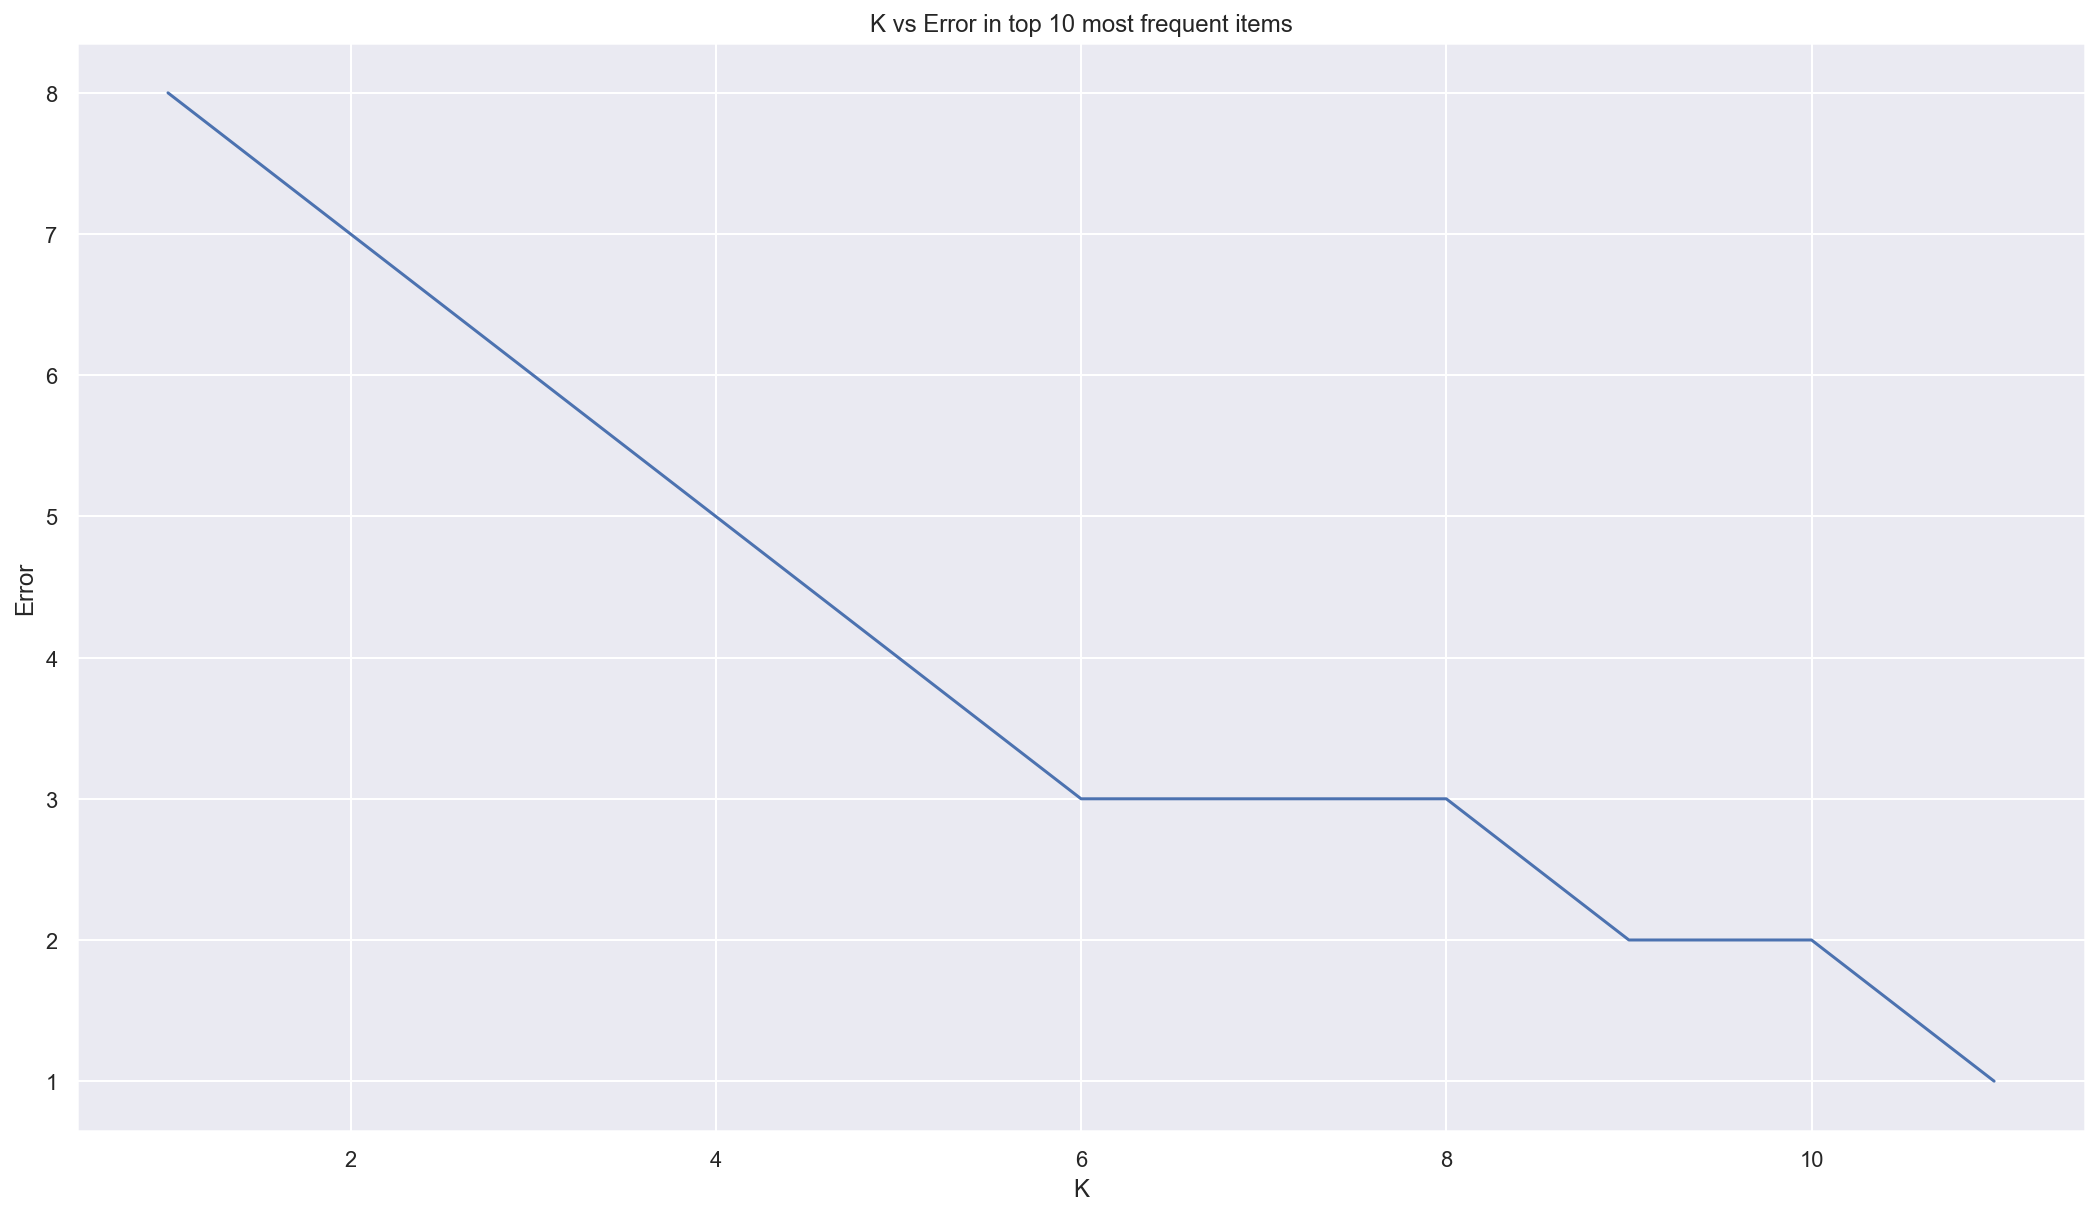

In [60]:
error=[]
for k in range(1,12):
    top10_SV=SpaceSpaver(Combined_feature,3,k)
    error.append(len(list(set(top10.keys())-set(top10_SV.keys()))))
ax=sns.lineplot(x=range(1,12),y=error)
ax.set_title("K vs Error in top 10 most frequent items")
ax.set_xlabel("K")
ax.set_ylabel("Error")
plt.show()    

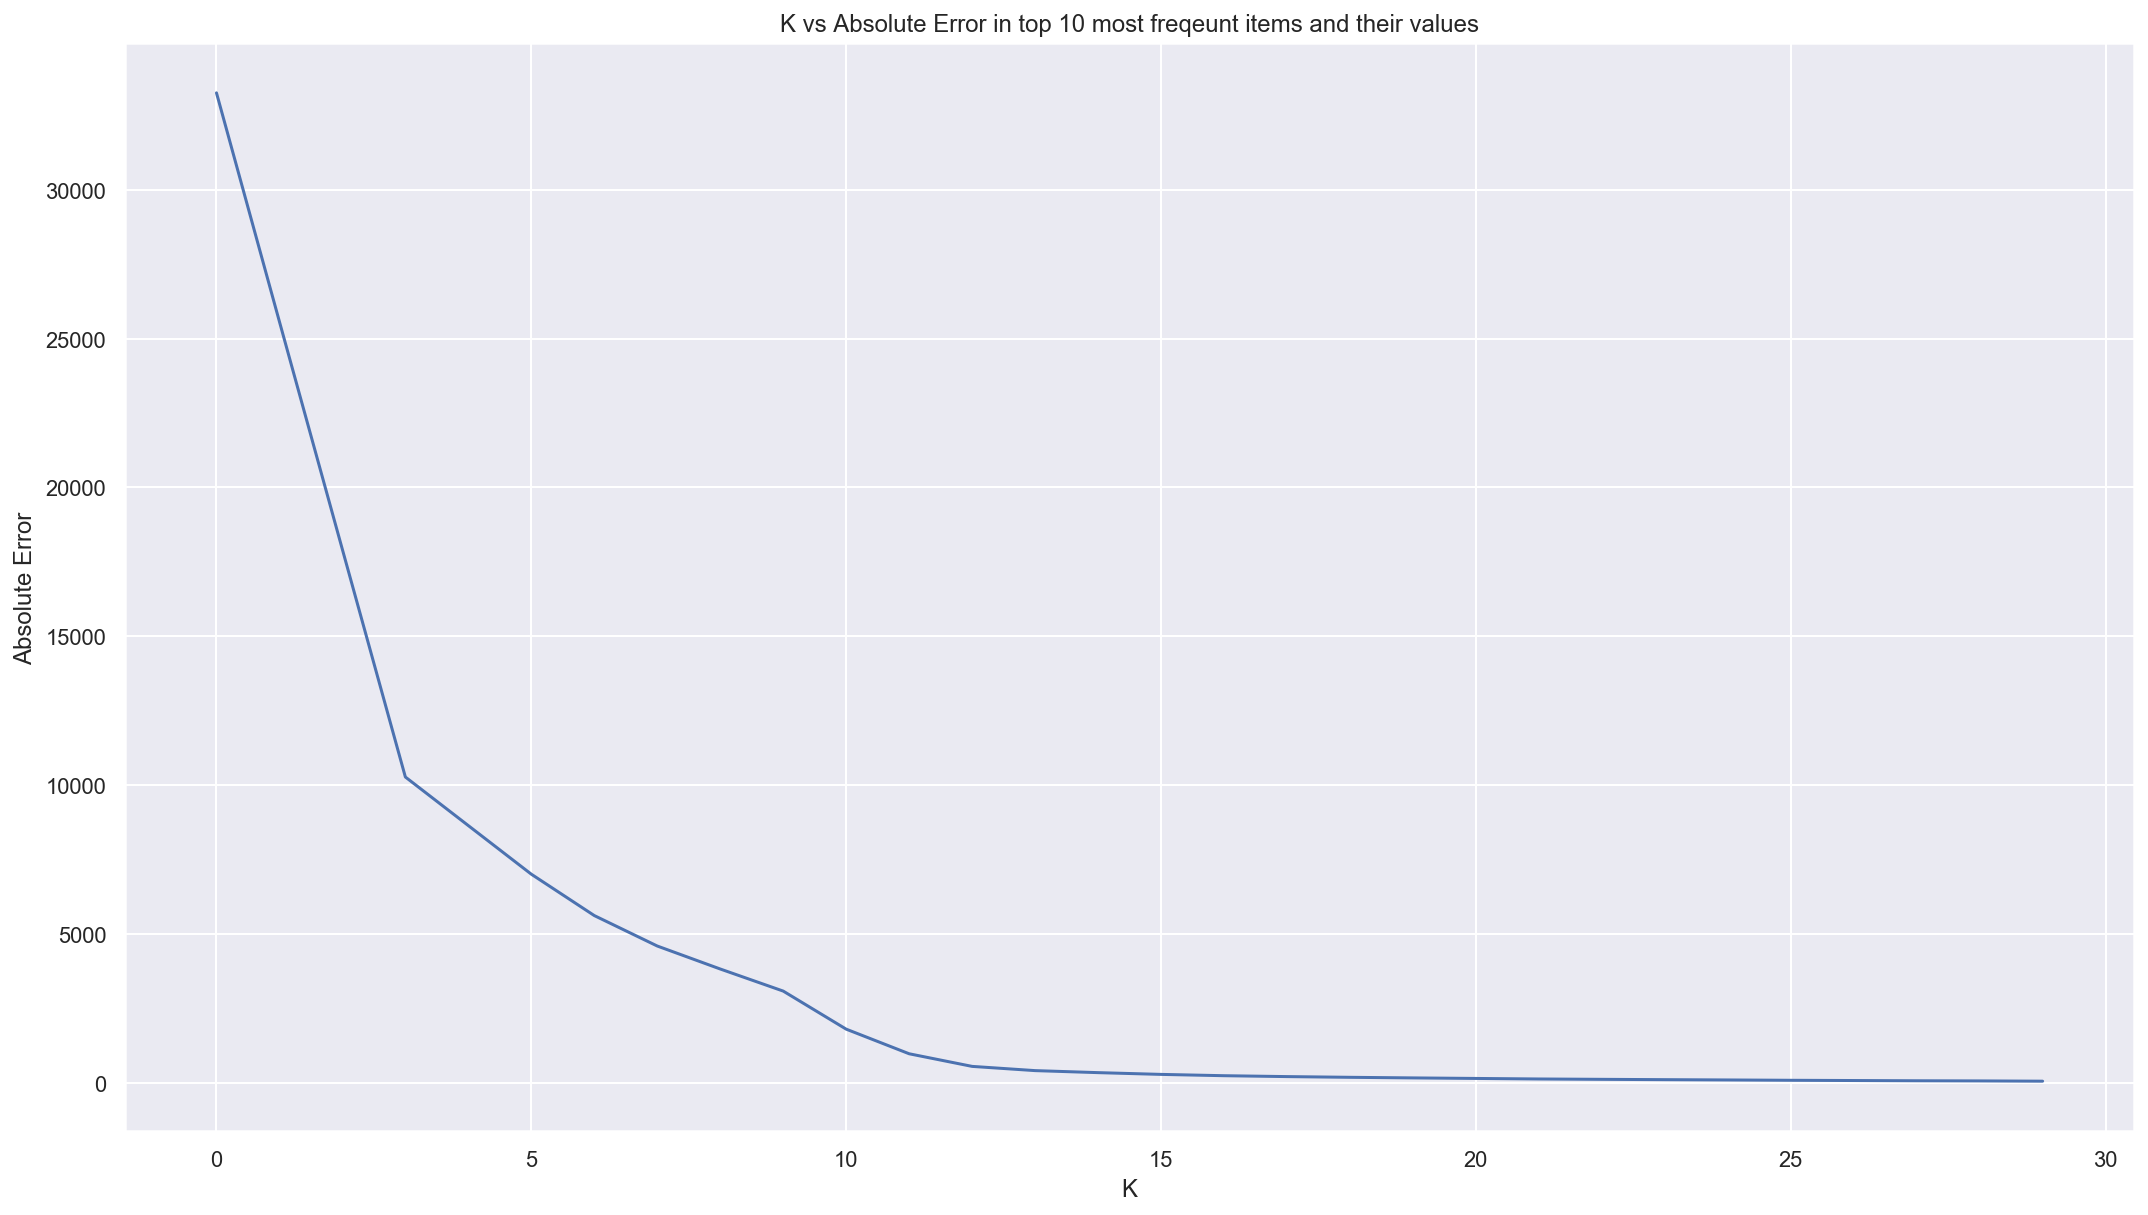

In [61]:
abserror=[]
for k in range(30):
    top10_SV=SpaceSpaver(Combined_feature,3,k)
    aberr=[]
    for i,j in zip(top10_SV.values(),top10.values()):
            aberr.append(abs(j-i))
    
    abserror.append(sum(aberr))
ax=sns.lineplot(x=range(30),y=abserror)
ax.set_title("K vs Absolute Error in top 10 most freqeunt items and their values")
ax.set_xlabel("K")
ax.set_ylabel("Absolute Error")
plt.show()    

Using more counters increases the overall accuracy of the counts of the elements as well as shown in the graph.

We see that the dataset is clearly skewed based on the barplots shown before. The basic intuition of the space saving algorithm is to make use of the skewed property of the data, since we expect a minority of the elements that are the more frequent ones to get the majority of the hits. Frequent elements will reside in the counters of bigger values, and will not be distorted by the ineffective hits of the infrequent elements, and thus, will never be replaced out of
the monitored counters. Meanwhile, the numerous infrequent elements will be
striving to reside on the smaller counters, whose values will grow slower than
those of the larger counters. The elements that
are growing more popular will gradually be pushed to the top of the list as they
receive more hits. If one of the previously popular elements lost its popularity,
it will receive less hits. Thus, its relative position will decline, as other counters
get incremented, and it might eventually get dropped from the list.
Even if the data is not skewed, the errors in the counters will be inversely
proportional to the number of counters, this is also shown by my graphs as well. Keeping only a moderate
number of counters will guarantee very small errors. This is because the more
counters we keep, the less it is probable to replace elements, and thus, the smaller
the over-estimation errors in counters’ values. 

Note- I must give credit to the authors of the actual space saving paper as the source for this explanation. 

## 3. Sketching task – Anwesh Marwade

### 3a. COUNT-MIN sketch


In [50]:
# Scenario 10
data_discrete = data_discretizer(data1)
discretized = data_discrete.Combined_Levels.values

# Creating the different n-grams.
n = 3
threegrams = ngrams(discretized, n)

# Creating a dictionary that stores the counts for the different ngrams. 
gram_freq={}
stream_grams = []
for i in threegrams:
    s = []
    for gram in i:
        s.append(re.findall("\d+",gram)[0])
    
    g = ''.join(s)
    stream_grams.append(g)
    gram_freq[g] = gram_freq.get(g, 0) + 1

# Sorting the ngram_freq dictionary for return top 10 occuring n-grams.
gram_freq={k: v for k, v in sorted(gram_freq.items(), key=lambda item: -1*item[1])} 

# Returning top 10 as demanded in the task.
top10 = {k: gram_freq[k] for k in list(gram_freq)[:10]}
top10_ngrams = list(top10.values())

In [51]:
# Count min sketch


class Countminsketch:
    def __init__(self, w, num_hash):
        ''' 
        Method to init the data structure
        width (int): Width of the sketch table or number of posible hash values
        num_hash (int): Depth of the sketch table (also =number of hash functions)
        '''
        self.width = w
        self.num_hash = num_hash
        self.table = np.zeros([num_hash, w])  # Creating an empty table
        self.seed = np.random.randint(w, size = num_hash) 

    def increment(self, key):
        ''' 
        Method to increment count of the string under consideration.
        '''
        for i in range(0, self.num_hash):
            index = mmh3.hash(key, self.seed[i]) % self.width
            
            self.table[i, index] = self.table[i, index]+1
            
    def estimate_freq(self, key):
        ''' 
        Method to estimate the frequency of the key (string that is passed as argument)
        '''
        min_arr = []
        for i in range(0, self.num_hash):
            index = mmh3.hash(key, self.seed[i]) % self.width
            min_arr.append(self.table[i, index])
            
        return min(min_arr)
    
    def show_table(self):
        return self.table
    
def CMS_wrapper_top_10(w, d, data):
    cms = Countminsketch(w, d)
    for i in stream_grams:
        cms.increment(i)
    countmin_dict = {}
    for gram in set(stream_grams):
        countmin_dict[gram] = int(cms.estimate_freq(gram))
    top10 = {k: v for k, v in sorted(countmin_dict.items(), key=lambda item: -1*item[1])}
    return list(top10.values())[:10]

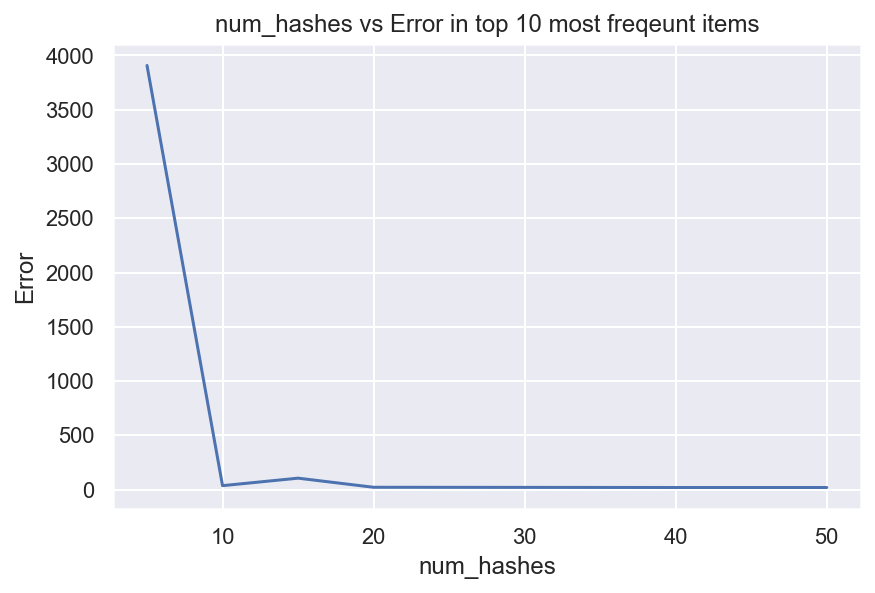

In [68]:
# top10_cms = CMS_wrapper_top_10(10, 15, stream_grams)
# top10_cms
hashes = [1, 5, 10, 15, 20, 40, 50]
error = np.zeros(len(hashes))
for idx, j in enumerate(hashes):
    top10_cms = CMS_wrapper_top_10(10, j, stream_grams)
    error[idx] = (sum([a_i - b_i for a_i, b_i in zip(top10_cms, top10_ngrams)]))
    
ax=sns.lineplot(x=hashes[1:],y=error[1:])
ax.set_title("num_hashes vs Error in top 10 most freqeunt items")
ax.set_xlabel("num_hashes")
ax.set_ylabel("Error")
plt.show()

### 3b. Analysis and answers to the questions

## LSH-Task: Common functions

In [69]:
# data_discrete needs to be different for this .... we'll talk on call 
data_discrete = data_discretizer(data1, "full")
src=data_discrete["SrcAddr"].values
dst=data_discrete["DstAddr"].values
ip_pairs=[]
for i,j in zip(src,dst):
    ip_pairs.append((i,j))
unique_pairs=list(set(ip_pairs)) 

#Getting the combined_features for each IP-pair and creating n-grams. 
datasubsets=[]
for i in set(unique_pairs):
    datasubsets.append(data_discrete.loc[(data_discrete["SrcAddr"]==i[0])&(data_discrete["DstAddr"]==i[1])])

Combined_pairF=[]
for i in datasubsets:
    Combined_pairF.append(i["Combined_levels"].values)    

Ngram_combined_pairF=[]

for i in Combined_pairF:
    threegrams = ngrams(i, 3)
    Ngram_combined_pairF.append(threegrams)     
    
# pairwise_ngrams n-grams frequncy for each ip-pair.     
pairwise_ngrams=[]
for i in Ngram_combined_pairF:
    pairwise_ngram={}
    for j in i:
        s = "-"
        s = s.join(j)
        pairwise_ngram[s] = pairwise_ngram.get(s, 0) + 1
    
    pairwise_ngrams.append(pairwise_ngram) 

    #Removing the empty ip_pairs.
index=[]
for i in enumerate(pairwise_ngrams):
    if len(list(i[1].keys()))!=0:
        index.append(i[0]) 
pairwise_ngrams_pure = [i[1] for i in enumerate(list(pairwise_ngrams)) if i[0] in index]        
pairwise_ngrams=pairwise_ngrams_pure

KeyError: 'DstAddr'

## 4. Min-wise locality sensitive hashing task – Aditya Kunar

For this task-:

1) I first obtain the ip pairs. 

2) I then extract the combined_feature that was used in task1 from the ip-pair subsets and create n-grams. 

3) I filter the ip-pairs which do not have any 3-grams as they do not need to be hashed.

4) I create the min-hash table.

5) I perform the algorithm of minwise LSH hashing to get the signature matrix.

6) I finally compare the errors of the jaccard similarity with the signiture similarity based on the number of hash functions and the number of bins used.

### 4a. Implementation

In [92]:
#getting the unique IP pairs.
src=data_discrete["SrcAddr"].values
dst=data_discrete["DstAddr"].values
ip_pairs=[]
for i,j in zip(src,dst):
    ip_pairs.append((i,j))
unique_pairs=list(set(ip_pairs))

#Getting the combined_features for each IP-pair and creating n-grams. 
datasubsets=[]
for i in set(unique_pairs):
    datasubsets.append(data_discrete.loc[(data_discrete["SrcAddr"]==i[0])&(data_discrete["DstAddr"]==i[1])])

Combined_pairF=[]
for i in datasubsets:
    Combined_pairF.append(i["Combined_levels"].values)    
    
Ngram_combined_pairF=[]

for i in Combined_pairF:
    threegrams = ngrams(i, 3)
    Ngram_combined_pairF.append(threegrams)     
    
# Big dicky stores the different n-grams and their counts for each ip-pair.     
BigDicky=[]
for i in Ngram_combined_pairF:
    dicky={}
    for j in i:
        s = "-"
        s = s.join(j)
        dicky[s] = dicky.get(s, 0) + 1
    
    BigDicky.append(dicky)    

#Removing the empty ip_pairs.
index=[]
for i in enumerate(BigDicky):
    if len(list(i[1].keys()))!=0:
        index.append(i[0]) 
BigDicky_pure = [i[1] for i in enumerate(list(BigDicky)) if i[0] in index]        
BigDicky=BigDicky_pure

#Total number of the different n-gram types. 
allkeys=[]
for i in BigDicky:
    for j in list(i.keys()):
        allkeys.append(j)
len(set(allkeys)) 

134

In [93]:
len(BigDicky)

303

In [94]:
BigDicky

[{'Combined_Level_2-Combined_Level_2-Combined_Level_2': 5},
 {'Combined_Level_2-Combined_Level_2-Combined_Level_2': 5,
  'Combined_Level_2-Combined_Level_2-Combined_Level_3': 1,
  'Combined_Level_2-Combined_Level_3-Combined_Level_2': 1},
 {'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1},
 {'Combined_Level_1-Combined_Level_1-Combined_Level_1': 5},
 {'Combined_Level_1-Combined_Level_1-Combined_Level_1': 2},
 {'Combined_Level_2-Combined_Level_2-Combined_Level_2': 17,
  'Combined_Level_2-Combined_Level_2-Combined_Level_1': 1,
  'Combined_Level_2-Combined_Level_1-Combined_Level_1': 1,
  'Combined_Level_1-Combined_Level_1-Combined_Level_1': 2,
  'Combined_Level_1-Combined_Level_1-Combined_Level_2': 1,
  'Combined_Level_1-Combined_Level_2-Combined_Level_2': 1},
 {'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1},
 {'Combined_Level_2-Combined_Level_2-Combined_Level_2': 6,
  'Combined_Level_2-Combined_Level_2-Combined_Level_1': 1,
  'Combined_Level_2-Combined_Level_1-Combined_Le

In [79]:
#creating the minhash table as described in the lecture.
# Here the rows are the ip-pair profiles and the columns are the different n-gram types.
# 1 indicates that the ngram was present and 0 otherwise. 
df=pd.DataFrame(np.zeros((len(BigDicky),len(list(set(allkeys))))),columns=list(set(allkeys)))

for k in enumerate(BigDicky):
    for i in df.columns:
        if i in list(k[1].keys()):
            df.loc[k[0],i]=1

In [80]:
#Transposing this dataframe to get the proper minhash table where columns are the profiles and rows are different n-grams. 
minhashtable=df.values.T

In [81]:
#This calculates the jaccard_similarity. 
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

#Prepocessing step to get the indexes of the ones to compute jaccard similarity. 
indexes=[]
for i in range(minhashtable.shape[1]):
    index=[x[0] for x in enumerate(minhashtable[:,i]) if x[1]==1]
    indexes.append(index)

In [95]:
indexes

[[41],
 [41, 114, 125],
 [41],
 [6],
 [6],
 [6, 23, 41, 84, 104, 126],
 [41],
 [6, 23, 26, 33, 41, 84, 104, 110, 115, 125, 126],
 [6],
 [86, 87],
 [104],
 [41],
 [6],
 [6],
 [23, 41, 84, 104, 126],
 [6, 23, 41, 63, 79, 84, 98, 104, 108, 115, 126],
 [23],
 [41],
 [23, 104, 126],
 [23],
 [41, 126],
 [6, 23, 30, 41, 84, 104, 114, 125, 126],
 [88],
 [6, 10, 23, 41, 54, 74, 84, 89, 104, 108, 118, 125, 126, 131],
 [41],
 [6, 104, 115],
 [98],
 [6],
 [1,
  6,
  9,
  11,
  12,
  23,
  35,
  42,
  46,
  48,
  50,
  53,
  58,
  73,
  79,
  90,
  91,
  95,
  99,
  104,
  111,
  113,
  115,
  118,
  119,
  120,
  122,
  123,
  129],
 [41],
 [41, 108, 118, 131],
 [6, 23, 41, 63, 77, 79, 84, 104, 105, 108, 125, 126],
 [6,
  11,
  23,
  25,
  35,
  38,
  42,
  48,
  50,
  53,
  58,
  79,
  90,
  91,
  95,
  99,
  104,
  105,
  115,
  118,
  120,
  122,
  123,
  129],
 [6, 23, 104, 115],
 [10, 41, 108, 131],
 [6],
 [41],
 [6],
 [6, 10, 23, 41, 57, 74, 84, 99, 104, 108, 114, 115, 125, 131],
 [13, 60],


In [82]:
#Timing the operation of calculating all pair-wise jaccard similarities. 
t1=time.perf_counter()
pair_wise_sim=[]
for i in indexes:
    for j in indexes:
        pair_wise_sim.append(jaccard_similarity(i,j))
pair_wise_sim=np.array(pair_wise_sim).reshape(len(BigDicky),len(BigDicky))
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")
# It must be noted that operations on sets in python is very fast in general.


Time to execute this was 0.11499470000035217 seconds.


In [83]:
#Seeing the pair_wise_similarity for each ip_pair. 
pd.DataFrame(pair_wise_sim)

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
0,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,1.000000,0.090909,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,1.000000,0.000000
1,0.333333,1.000000,0.333333,0.000000,0.000000,0.125000,0.333333,0.166667,0.000000,0.0,...,0.0,0.25,0.000000,0.285714,0.333333,0.75,0.000000,0.000000,0.333333,0.000000
2,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,1.000000,0.090909,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,1.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.000000,0.090909,1.000000,0.0,...,0.0,0.00,0.142857,0.000000,0.000000,0.00,0.333333,1.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.000000,0.090909,1.000000,0.0,...,0.0,0.00,0.142857,0.000000,0.000000,0.00,0.333333,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.250000,0.750000,0.250000,0.000000,0.000000,0.111111,0.250000,0.153846,0.000000,0.0,...,0.0,0.20,0.000000,0.428571,0.250000,1.00,0.000000,0.000000,0.250000,0.000000
299,0.000000,0.000000,0.000000,0.333333,0.333333,0.125000,0.000000,0.076923,0.333333,0.0,...,0.0,0.00,0.111111,0.000000,0.000000,0.00,1.000000,0.333333,0.000000,0.333333
300,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.000000,0.090909,1.000000,0.0,...,0.0,0.00,0.142857,0.000000,0.000000,0.00,0.333333,1.000000,0.000000,1.000000
301,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,1.000000,0.090909,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,1.000000,0.000000


In [84]:
# Defining the number of hash functions and number of bins to be used.

"""
hash_func_gen=> It is used to generate the hash functions. 
                Inputs:-
                N-> Controls the number of hash functions to be generated.
                b-> Controls the number of bins we want. b has to be greater than 1. 
                    b doesn't directly correspond to number of bins, for ex 
                    if b=2 it's not going to be 2 bins. But basically if you want more bins
                    you provide a higher b value. 
"""
def hash_func_gen(N,bc):
    N_HASHES = N

    #Creating the different hash functions. 
    def universal_hashing():
        def rand_prime():
            while True:
                p = random.randrange(2 **1 , 2 ** bc, 2)
                if all(p % n != 0 for n in range(3, int((p ** 0.5) + 1), 2)):
                    return p
        m = 2 ** 32 - 1
        p = rand_prime()
        a = random.randint(0, p)
        if a % 2 == 0:
            a += 1
        b = random.randint(0, p)
        def h(x):
            return ((a * x + b) % p) % m
        return h

    hash_funcs = []
    for i in range(N_HASHES):
        hash_funcs.append(universal_hashing())
    return hash_funcs 

In [96]:
#Generating the hash_funcs
No_hash_funcs=50
hash_funcs=hash_func_gen(No_hash_funcs,3)

In [97]:
#Defining M the signature matrix. 
M= np.full((No_hash_funcs, len(BigDicky)), np.inf)
M

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [98]:
# This is where i perform the min-wis LSH to get the signature matrix. 
for i in range(minhashtable.shape[0]):
    hash_vals=[h(i) for h in hash_funcs]
    for j in range(minhashtable.shape[1]):
        c= minhashtable[:,j]
        if c[i]==1:
            for v in enumerate(hash_vals):
                if v[1] < M[v[0],j]:
                    M[v[0],j]=v[1]
        else:
            continue

In [99]:
#What M looks like.
M

array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 3., 0., 3.],
       [1., 1., 1., ..., 2., 1., 2.],
       ...,
       [0., 0., 0., ..., 3., 0., 3.],
       [3., 2., 3., ..., 2., 3., 2.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [100]:
#Here i compute the signature similarity. 
t1=time.perf_counter()
pair_wise_M_sim=[]
for i in range(M.shape[1]):
    for j in range(M.shape[1]):
            pair_wise_M_sim.append(((M[:,i]==M[:,j]).sum())/50)
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.") 

Time to execute this was 0.4263989000000947 seconds.


In [101]:
#Pair_wise Signature similarity between ip_pair profiles. 
pd.DataFrame(np.array(pair_wise_M_sim).reshape(len(BigDicky),len(BigDicky)))

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
0,1.00,0.42,1.00,0.00,0.00,0.36,1.00,0.36,0.00,0.14,...,0.68,0.42,0.36,0.28,1.00,0.38,0.28,0.00,1.00,0.00
1,0.42,1.00,0.42,0.58,0.58,0.88,0.42,0.88,0.58,0.58,...,0.24,1.00,0.88,0.82,0.42,0.94,0.82,0.58,0.42,0.58
2,1.00,0.42,1.00,0.00,0.00,0.36,1.00,0.36,0.00,0.14,...,0.68,0.42,0.36,0.28,1.00,0.38,0.28,0.00,1.00,0.00
3,0.00,0.58,0.00,1.00,1.00,0.52,0.00,0.52,1.00,0.56,...,0.00,0.58,0.52,0.54,0.00,0.56,0.54,1.00,0.00,1.00
4,0.00,0.58,0.00,1.00,1.00,0.52,0.00,0.52,1.00,0.56,...,0.00,0.58,0.52,0.54,0.00,0.56,0.54,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.38,0.94,0.38,0.56,0.56,0.94,0.38,0.94,0.56,0.58,...,0.24,0.94,0.94,0.88,0.38,1.00,0.88,0.56,0.38,0.56
299,0.28,0.82,0.28,0.54,0.54,0.86,0.28,0.88,0.54,0.60,...,0.14,0.82,0.88,0.94,0.28,0.88,1.00,0.54,0.28,0.54
300,0.00,0.58,0.00,1.00,1.00,0.52,0.00,0.52,1.00,0.56,...,0.00,0.58,0.52,0.54,0.00,0.56,0.54,1.00,0.00,1.00
301,1.00,0.42,1.00,0.00,0.00,0.36,1.00,0.36,0.00,0.14,...,0.68,0.42,0.36,0.28,1.00,0.38,0.28,0.00,1.00,0.00


In [91]:
#Error between jaccard and signature similarity. 
errors=(pair_wise_sim-np.array(pair_wise_M_sim).reshape(len(BigDicky),len(BigDicky)))**2
err=(errors.ravel().sum())/len(errors.ravel())
err

0.04634748471702171

### 4b. Analysis and answers to the questions

In [102]:
#Affect of increasing number of bins. 
e=[]
b=[2,3,4,5,6]
for i in b:
    No_hash_funcs=50
    hash_funcs=hash_func_gen(No_hash_funcs,i)
    print("Number of bins being used "+str(max([h(1) for h in hash_funcs])+1))
    M= np.full((No_hash_funcs,len(BigDicky)), np.inf)
    for i in range(minhashtable.shape[0]):
        hash_vals=[h(i) for h in hash_funcs]
        for j in range(minhashtable.shape[1]):
            c= minhashtable[:,j]
            if c[i]==1:
                for v in enumerate(hash_vals):
                    if v[1] < M[v[0],j]:
                        M[v[0],j]=v[1]
            else:
                continue
    pair_wise_M_sim=[]
    for i in range(M.shape[1]):
        for j in range(M.shape[1]):
                pair_wise_M_sim.append(((M[:,i]==M[:,j]).sum())/50)
    errors=(pair_wise_sim-np.array(pair_wise_M_sim).reshape(len(BigDicky),len(BigDicky)))**2
    err=(errors.ravel().sum())/len(errors.ravel())
    print(err)


Number of bins being used 2
0.3144076182367693
Number of bins being used 6
0.15287675260062594
Number of bins being used 14
0.0737860205107577
Number of bins being used 25
0.0330365169901879
Number of bins being used 54
0.012352859073234523


The cool thing about using minhash table is that jaccard similarity is approximated as signature similarity as this is a property of the algorithm. The reason why this is faster is perhaps because we have lesser rows represented by the number of hash functions used in the signature matrix which is much lesser than the total number of different N-grams for the original minhash table for computing jaccard similarity. In my case it wasn't faster but this is because I had only 134 different N-grams types. This number is much bigger for common datasets and so the speed up is more advantageous if one has more different n-gram types. Moreover we see that error goes down with the more number of bins used to hash the row values as well. So in conclusion we see if we use more bins to hash row values, the approximate error in the values goes down and the speed up can be increased if we use lesser hash functions overall. Basically if we have more bins, we can more appropriately appoximate random permutation of the row number values and as this leads to a better constructed signature matrix, the error is lesser.


## 5. Random hyperplane locality sensitive hashing task- Anwesh Marwade

### 5a. Implementation - locality sensitive hashing

In [ ]:
def lsh_hyperplanes(data, num_planes):
    r = np.zeros((num_planes, len(data[0])))
    for i in range(num_planes):
        r[i] = np.random.randn(len(data[0]))

    # for idx in range(len(df.values)):
    prod = np.zeros((len(data), num_planes))
    prod = np.dot(data, r.T)
    prod = np.where(prod > 0, 1, 0)
    hash_bins = []
    for i in range(len(prod)):
        hash_bins.append(''.join(str(x) for x in prod[i]))
    return hash_bins

In [ ]:
# df.drop(['hash_bins'], axis=1, inplace=True)
hash_bins = lsh_hyperplanes(df.values, num_planes = 3)
df['hash_bins'] = pd.DataFrame(hash_bins)

In [ ]:
# import math
def euclideanDistance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)
df.hash_bins.unique()

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances
df_copy = df.drop(['hash_bins'], axis=1)
t1=time.perf_counter()
# euc_dist = euclidean_distances(df.drop(['hash_bins'], axis=1).values, df.drop(['hash_bins'], axis=1).values)
num_records = len(df_copy)
euc_dist=np.zeros((num_records, num_records))
for i in range(num_records):
    for j in range(num_records):
            euc_dist[i][j] = euclideanDistance(df_copy.values[i], df_copy.values[j])
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")

In [ ]:
t1=time.perf_counter()
for hash_code in df.hash_bins.unique():
    df_copy = df[df['hash_bins'] == hash_code].drop(['hash_bins'], axis=1)
    num_records = len(df_copy)
    euc_dist=np.zeros((num_records, num_records))
    for i in range(num_records):
        for j in range(num_records):
                euc_dist[i][j] = euclideanDistance(df_copy.values[i], df_copy.values[j])
#     print(euc_dist)
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

In [114]:
def Ngram_profile_generator(data_discrete):
    data = data_discrete.copy()
        #All source Ips.
    Srcs=set(data["SrcAddr"].values)
    # The malicious source IPs or hosts. 
    M_src=set(data.loc[data["Labels"]==1]["SrcAddr"].values)

    #Getting the combined_features for each source IP and creating n-grams. 
    datasubsets=[]
    for i in Srcs:
        datasubsets.append(data.loc[(data["SrcAddr"]==i)])

    # Discretized flow per source
    sequence_per_src=[]
    for i in datasubsets:
        sequence_per_src.append(i["Combined_Levels"].values)

    ngrams_per_src = []

    for i in sequence_per_src:
        threegrams = ngrams(i, 3)
        ngrams_per_src.append(threegrams)

    ngrams_profile_per_src=[]
    for i in ngrams_per_src:
        ngram_map={}
        for j in i:
            s = "-"
            s = s.join(j)
            ngram_map[s] = ngram_map.get(s, 0) + 1

        ngrams_profile_per_src.append(ngram_map)

    # To remove an blanks in case they occur
    index=[]
    for i in enumerate(ngrams_profile_per_src):
        if len(list(i[1].keys()))!=0:
            index.append(i[0])
    ngrams_profile_per_src_pure = [i[1] for i in enumerate(list(ngrams_profile_per_src)) if i[0] in index]        
    ngrams_profile_per_src=ngrams_profile_per_src_pure

    ind=list(set(Srcs)-(set(Srcs)-set(index)))

    unique_ngrams_list=[]
    for i in ngrams_profile_per_src:
        for j in list(i.keys()):
            unique_ngrams_list.append(j)
    unique_ngrams_list = set(unique_ngrams_list)

    df = pd.DataFrame(np.zeros((len(ngrams_profile_per_src),len(unique_ngrams_list))), columns=unique_ngrams_list)

    for idx, k in enumerate(ngrams_profile_per_src):
        for i in df.columns:
            if i in list(k.keys()):
                df.loc[idx, i]=k[i]

    df=df.set_index(pd.Series(list(ind))) 
    M_df=df.loc[M_src,:]
    N_df= df.loc[list(set(ind)-set(M_src))]

    return df,M_df,N_df

### 6a. Learn a sequential model

In [115]:
def cosine_sim(a, b):
    return np.dot(a, b)/(norm(a)*norm(b))

def predict_malicious_profiles(data):
    df,M_df,N_df = Ngram_profile_generator(data)
    true_infections = list(M_df.index)
    for infections in true_infections:

        remaining_infections = [i for i in true_infections if i != infections]
        infected_host = df.loc[df.index == infections].values
        test_hosts = df.loc[df.index != infections]
        cosine_arr = []

        predicted_infections = []
        for row in test_hosts.iterrows():
            cosine_arr.append(cosine_sim(infected_host, row[1].values))
            if cosine_sim(infected_host, row[1].values) > 0:
                predicted_infections.append(row[0])
        TP = len(set(predicted_infections).intersection(remaining_infections))

        FP = len(set(predicted_infections)-set(remaining_infections))

        print("Total predictions: %d, True Positives: %d, False Positives: %d" %(len(predicted_infections), TP, FP))
        break


In [116]:
# # df,M_df,N_df = Ngram_profile_generator(data1_discrete)
print("-------Prediction for Netflow 9-------")
data0_discrete = data_discretizer(data0)
predict_malicious_profiles(data0_discrete)
print("\n-------Prediction for Netflow 10-------")
data1_discrete = data_discretizer(data1)
predict_malicious_profiles(data1_discrete)
print("\n-------Prediction for Netflow 11-------")
data2_discrete = data_discretizer(data2)
predict_malicious_profiles(data2_discrete)
print("\n-------Prediction for Netflow 12-------")
data3_discrete = data_discretizer(data3)
predict_malicious_profiles(data3_discrete)

-------Prediction for Netflow 9-------
Total predictions: 16, True Positives: 9, False Positives: 7

-------Prediction for Netflow 10-------
Total predictions: 16, True Positives: 9, False Positives: 7

-------Prediction for Netflow 11-------
Total predictions: 13, True Positives: 8, False Positives: 5

-------Prediction for Netflow 12-------
Total predictions: 5, True Positives: 2, False Positives: 3


## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


In [118]:
# Will be used for fingerprinting task and subsequent evaluation
data_discrete=data_discretizer(dataMerged)
data_discrete_train = data_discrete.sample(frac=0.5, replace=False, random_state=1)
data_discrete_eval = data_discrete.sample(frac=0.5, replace=False, random_state=1)

In [119]:
df,M_df,N_df = Ngram_profile_generator(data_discrete_train)
meansM= M_df.mean(axis=0)
meansN= N_df.mean(axis=0)
meanssM={}
for i,j in zip(meansM.index,meansM.values):
    meanssM[i]=j

meanssN={}
for i,j in zip(meansN.index,meansN.values):
    meanssN[i]=j

topNgramsM={k: v for k, v in sorted(meanssM.items(), key=lambda item: -1*item[1])}

# Print top 10 N grams in infected instances
dict(itertools.islice(topNgramsM.items(), 10))

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 11222.916666666666,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 385.9166666666667,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 385.6666666666667,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 384.75,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 49.5,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 49.083333333333336,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 48.666666666666664,
 'Combined_Level_4-Combined_Level_1-Combined_Level_4': 13.75,
 'Combined_Level_1-Combined_Level_4-Combined_Level_4': 13.25,
 'Combined_Level_4-Combined_Level_4-Combined_Level_1': 13.083333333333334}

In [120]:
# Print top 10 N grams in Benign instances
topNgramsN={k: v for k, v in sorted(meanssN.items(), key=lambda item: -1*item[1])}
dict(itertools.islice(topNgramsN.items(), 10))

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 1707.375,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 6.1875,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 6.0625,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 6.0625,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 5.25,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 5.25,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 5.1875,
 'Combined_Level_7-Combined_Level_7-Combined_Level_7': 1.375,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 0.25,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 0.25}

In [121]:
notpresentinNormal=[]
for i in topNgramsN:
    if (topNgramsN[i]==0):
        notpresentinNormal.append(i)

# print set of flows not seen in benign traffic
notpresentinNormal

['Combined_Level_6-Combined_Level_1-Combined_Level_4',
 'Combined_Level_7-Combined_Level_4-Combined_Level_1',
 'Combined_Level_1-Combined_Level_6-Combined_Level_1',
 'Combined_Level_4-Combined_Level_7-Combined_Level_4',
 'Combined_Level_6-Combined_Level_1-Combined_Level_1',
 'Combined_Level_4-Combined_Level_4-Combined_Level_4',
 'Combined_Level_1-Combined_Level_4-Combined_Level_4',
 'Combined_Level_4-Combined_Level_7-Combined_Level_1',
 'Combined_Level_4-Combined_Level_4-Combined_Level_7',
 'Combined_Level_1-Combined_Level_1-Combined_Level_6',
 'Combined_Level_1-Combined_Level_4-Combined_Level_7']

In [122]:
for i in notpresentinNormal:
    print("Value counts for this ngram in malicious data:\n"+i)
    print(topNgramsM[i])

Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_7-Combined_Level_4-Combined_Level_1
1.1666666666666667
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_6-Combined_Level_1
0.5
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_1
0.4166666666666667
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_4
0.6666666666666666
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_4-Combined_Level_4
13.25
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_1
1.0
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_7
0.08333

From this we see that all the N-grams which were not present in benign data were present in malicious data and therefore can be used for fingerprinting for malicious hosts.

In [123]:
df,M_df,N_df = Ngram_profile_generator(data_discrete_eval)
malicious=[]
for index, row in df.iterrows():
    c=0
    for ngram in notpresentinNormal:
        if ngram in df.columns:
            if row[ngram]>=0:
                c+=1
                if c==len(notpresentinNormal):
                    malicious.append(index)
                    break

#True positives.
TP = len(set(malicious).intersection(M_df.index))
#False postivies
FP = len(set(malicious)-set(M_df.index))
print("True Positives: %d, False Positives: %d" %(TP, FP))

True Positives: 12, False Positives: 16


### 7b. Analysis and answers to the questions.

As every row was considered to be malicious, the False Positives are 16 and the True Positives are 12.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.